In [1]:
import pandas as pd
from IPython.display import clear_output

In [198]:
import random
import numpy as np
import scipy.stats as st
from scipy.stats import linregress
import matplotlib.pyplot as plt

class DifferencingDecisionModel:
    
    def __init__(self):
        pass
        
    def convert_k_to_p(self, d_prime, k1, k2):
        
        p_k1_false = st.norm.cdf(-k1)
        p_k2_false = st.norm.cdf(-k2)
        p_false = p_k1_false + p_k2_false
        
        p_k1_hit = st.norm.cdf(-d_prime - k1) + st.norm.cdf(d_prime - k1)
        p_k2_hit = st.norm.cdf(-d_prime - k2) + st.norm.cdf(d_prime - k2)
        p_hit = (p_k1_hit + p_k2_hit)/2
        
        #print(f"P(f): {p_k1_false + p_k2_false}")
        #print(f"P(h): {(p_k1_hit + p_k2_hit)/2}")
        
        return p_false, p_hit
        
    def convert_k_to_z(self, d_prime, k1, k2):
        
        p_false, p_hit = self.convert_k_to_p(d_prime, k1, k2)
        return st.norm.ppf(p_false), st.norm.ppf(p_hit)
        
    def sample_k1_k2_values(self, k_range, d_prime, num_points):
        
        zf_vals = []
        zh_vals = []
        
        pf_vals = []
        ph_vals = []
        
        k_range = [n for n in np.linspace(k_range['k_min'], k_range['k_max'], k_range['k_num'])]
        for _ in range(num_points):
            k1 = random.choice(k_range)
            k2 = random.choice(k_range)
            z_f, z_h = self.convert_k_to_z(d_prime, k1, k2)
            
            zf_vals.append(z_f)
            zh_vals.append(z_h)
            
        return zf_vals, zh_vals
    
    def sample_k_values(self, k_range, d_prime, num_points):
        
        zf_vals = []
        zh_vals = []
        
        k_range = [n for n in np.linspace(k_range['k_min'], k_range['k_max'], k_range['k_num'])]
        for _ in range(num_points):
            k = random.choice(k_range)
            z_f, z_h = self.convert_k_to_z(d_prime, k, k)
            
            zf_vals.append(z_f)
            zh_vals.append(z_h)
            
        return zf_vals, zh_vals
        
    def generate_model(self, k_min, k_max, k_num, d_prime, k1=None):
        z_f_values = []
        z_h_values = []
        
        usek2 = True if k1 is None else False
        
        for k2 in np.linspace(k_min, k_max, k_num):
            if usek2:
                k1 = k2
            z_f, z_h = self.convert_k_to_z(d_prime, k1, k2)    
            
            z_f_values.append(z_f)
            z_h_values.append(z_h)
            
        return linregress(z_f_values, z_h_values)
        
    def fit_df1_model(self, k_range, dp_range, zf_vals, zh_vals):
        
        best_model = None
        lowest_mse = np.inf
        best_dp = 0
        
        for d_p in np.linspace(dp_range['dp_min'], dp_range['dp_max'], dp_range['dp_num']):
            model = self.generate_model(k_range['k_min'], k_range['k_max'], k_range['k_num'], d_p)
            
            y_pred = [model.intercept + model.slope * n for n in zf_vals]
            mse = np.mean([(y_a - y_p)**2 for y_a, y_p in zip(zh_vals, y_pred)])
            
            if mse < lowest_mse:
                lowest_mse = mse
                best_model = model
                best_dp = d_p
                
            clear_output()
                
        return best_model, best_dp, lowest_mse
    
    def fit_df2_model(self, k_range, dp_range, zf_vals, zh_vals):
        
        best_model = None
        lowest_mse = np.inf
        best_dp = 0
        
        for dp in np.linspace(dp_range['dp_min'], dp_range['dp_max'], dp_range['dp_num']):
            
            print(f"Checking d'={dp}.")
            for k1 in np.linspace(k_range['k_min'], k_range['k_max'], k_range['k_num']):
                model = self.generate_model(k_range['k_min'], k_range['k_max'], k_range['k_num'], dp, k1=k1)

                y_pred = [model.intercept + model.slope * n for n in zf_vals]
                mse = np.mean([(y_a - y_p)**2 for y_a, y_p in zip(zh_vals, y_pred)])

                if mse < lowest_mse:
                    lowest_mse = mse
                    best_model = model
                    best_dp = dp

            clear_output()
                
        return best_model, best_dp, lowest_mse
        

In [199]:
diff_model = DifferencingDecisionModel()

# DF2 k-Value Grid Sampling

Text(0.5, 1.0, "DF2 k-Sampling (d'=0.5, 0<k<4)")

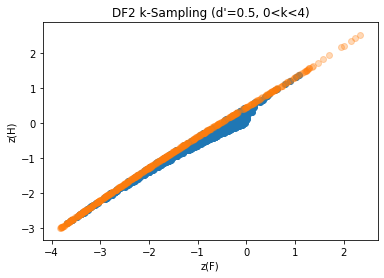

In [121]:
k_range = {'k_min': 0, 'k_max': 4, 'k_num': 1000}
zf_vals, zh_vals = diff_model.sample_k1_k2_values(k_range, 1, 500)
zf_vals_k, zh_vals_k = diff_model.sample_k_values(k_range, 1, 500)

plt.scatter(zf_vals, zh_vals)
plt.scatter(zf_vals_k, zh_vals_k, alpha=0.3)
plt.xlabel('z(F)')
plt.ylabel('z(H)')
plt.title('DF2 k-Sampling (d\'=0.5, 0<k<4)')
#plt.savefig('results/df2_sampling_smallk.png')

In [151]:
k_range = {'k_min': 0, 'k_max': 4, 'k_num': 101}
dp_range = {'dp_min': 0, 'dp_max': 2, 'dp_num': 11}

mb_data = pd.read_csv('mb_data.csv', index_col=0)
x_vals = [-4, 3]

for dp in np.linspace(dp_range['dp_min'], dp_range['dp_max'], dp_range['dp_num']):
    zf_vals, zh_vals = diff_model.sample_k1_k2_values(k_range, dp, 500)
    zf_vals_k, zh_vals_k = diff_model.sample_k_values(k_range, dp, 500)

    plt.gcf().set_size_inches(8, 6)
    plt.scatter(zf_vals, zh_vals, alpha=0.3, marker='^', facecolor="none", edgecolor='black', label='DF2')
    plt.scatter(zf_vals_k, zh_vals_k, alpha=0.3, marker='s', facecolor="none", edgecolor='black', label='DF1')
    for index, row in mb_data.iterrows():
        slope, intercept = row['Slope'], row['Intercept']
        pred_vals = [slope * n + intercept for n in x_vals]
        plt.plot(x_vals, pred_vals, color='black', alpha=0.1)
    plt.xlabel('z(F)')
    plt.ylabel('z(H)')
    plt.xlim(-4, 3)
    plt.ylim(-4, 3)
    plt.title(f'DF k-Value Sampling (d\'={round(dp,2)}, 0<k<4)')
    plt.legend()
    plt.savefig(f'results/k_sampling{round(dp,2)}.png')
    plt.clf()

<Figure size 576x432 with 0 Axes>

In [204]:
k_range = {'k_min': -4, 'k_max': 4, 'k_num': 201}
dp_range = {'dp_min': 0, 'dp_max': 2.5, 'dp_num': 26}

data = pd.read_csv('data.csv', index_col=0)
x_vals = [-4, 3]
explained_subs = ['BYZ','HP','HYP','SL','YPL','YJC','ZJT','QP','TCD','YCX','ZXL','ZY','CW','WJ','RSL','SJ2','LXL','SYB','WY','YJX','CY','GJ','JYN','SJ','SXQ','ZQT']

for dp in np.linspace(dp_range['dp_min'], dp_range['dp_max'], dp_range['dp_num']):
    zf_vals, zh_vals = diff_model.sample_k1_k2_values(k_range, dp, 1000)

    plt.gcf().set_size_inches(8, 6)
    plt.scatter(zf_vals, zh_vals, alpha=0.3, marker='^', facecolor="none", edgecolor='black')

    for i in range(len(data)):
        sub_data = data.iloc[i]
        if sub_data['Subject'] in explained_subs:
            alpha = 0.3
            zf_vals = sub_data.filter(like='ZF').tolist()
            zh_vals = sub_data.filter(like='ZH').tolist()
            plt.plot(zf_vals, zh_vals, color='black', alpha=alpha)    
    
    plt.xlabel('z(F)')
    plt.ylabel('z(H)')
    plt.xlim(-4, 3)
    plt.ylim(-4, 3)
    plt.title(f'DF2 k-Value Sampling (d\'={round(dp,2)}, -4<k<4)')
    plt.savefig(f'results/k_sampling{round(dp,2)}.png')
    plt.clf()


<Figure size 576x432 with 0 Axes>

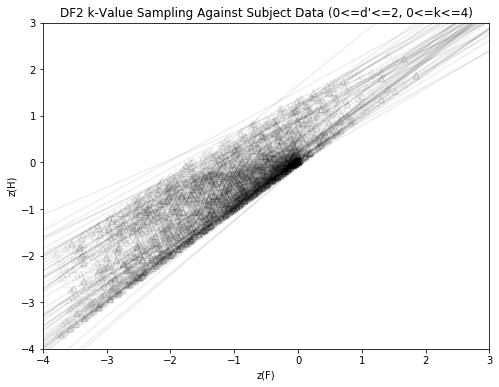

In [164]:
k_range = {'k_min': 0, 'k_max': 4, 'k_num': 101}
dp_range = {'dp_min': 0, 'dp_max': 3, 'dp_num': 11}

mb_data = pd.read_csv('mb_data.csv', index_col=0)
x_vals = [-4, 3]

plt.gcf().set_size_inches(8, 6)
for dp in np.linspace(dp_range['dp_min'], dp_range['dp_max'], dp_range['dp_num']):
    zf_vals, zh_vals = diff_model.sample_k1_k2_values(k_range, dp, 500)
    #zf_vals_k, zh_vals_k = diff_model.sample_k_values(k_range, dp, 500)

    plt.scatter(zf_vals, zh_vals, alpha=0.07, marker='^', facecolor="none", edgecolor='black')
    #plt.scatter(zf_vals_k, zh_vals_k, alpha=0.3, marker='s', facecolor="none", edgecolor='black', label='DF1')
    
for index, row in mb_data.iterrows():
    slope, intercept = row['Slope'], row['Intercept']
    pred_vals = [slope * n + intercept for n in x_vals]
    plt.plot(x_vals, pred_vals, color='black', alpha=0.07)

plt.xlabel('z(F)')
plt.ylabel('z(H)')
plt.xlim(-4, 3)
plt.ylim(-4, 3)
plt.title(f'DF2 k-Value Sampling Against Subject Data (0<=d\'<=2, 0<=k<=4)')  
plt.savefig(f'results/k_sampling_full.png')

# Testing DF Model Against Subject LoBF

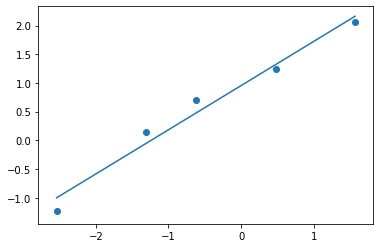

In [7]:
deg8_data = pd.read_csv('data_8degree.csv', index_col=0)
sub_data = deg8_data.iloc[3]
zf_vals = sub_data.filter(like='ZF').tolist()
zh_vals = sub_data.filter(like='ZH').tolist()

model = linregress(zf_vals, zh_vals)
y_pred = [model.intercept + model.slope * n for n in zf_vals]
plt.plot(zf_vals, y_pred)
plt.scatter(zf_vals, zh_vals)

Text(0.5, 1.0, 'DF1 Model Fit')

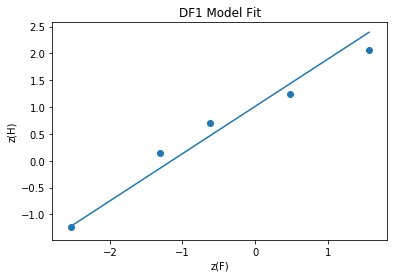

In [8]:
k_range = {'k_min': 0.1, 'k_max': 5, 'k_num': 100}
dp_range = {'dp_min': 0.5, 'dp_max': 2, 'dp_num': 150}

model, dp, mse = diff_model.fit_df1_model(k_range, dp_range, zf_vals, zh_vals)

y_pred = [model.intercept + model.slope * n for n in zf_vals]
plt.plot(zf_vals, y_pred)
plt.scatter(zf_vals, zh_vals)
plt.xlabel('z(F)')
plt.ylabel('z(H)')
plt.title('DF1 Model Fit')

Text(0.5, 1.0, 'DF2 Model Fit')

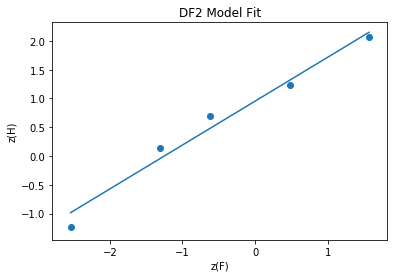

In [9]:
k_range = {'k_min': 0, 'k_max': 5, 'k_num': 50}
dp_range = {'dp_min': 0.5, 'dp_max': 2, 'dp_num': 75}

model, dp, mse = diff_model.fit_df2_model(k_range, dp_range, zf_vals, zh_vals)

y_pred = [model.intercept + model.slope * n for n in zf_vals]
plt.plot(zf_vals, y_pred)
plt.scatter(zf_vals, zh_vals)
plt.xlabel('z(F)')
plt.ylabel('z(H)')
plt.title('DF2 Model Fit')

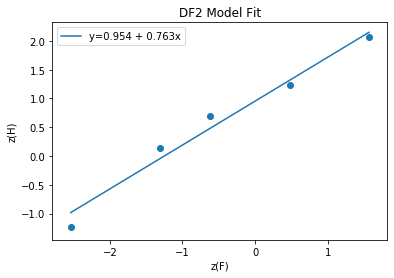

In [14]:
y_pred = [model.intercept + model.slope * n for n in zf_vals]
plt.plot(zf_vals, y_pred)
plt.scatter(zf_vals, zh_vals)
plt.xlabel('z(F)')
plt.ylabel('z(H)')
plt.title('DF2 Model Fit')
plt.legend([f'y={round(model.intercept,3)} + {round(model.slope, 3)}x'])

In [74]:
k1_range = {'k_min': 0, 'k_max': 5, 'k_num': 100}
data_pf = []
data_ph = []
for k2 in range(0, 5):
    k_data_pf = []
    k_data_ph = []
    for k1 in np.linspace(k1_range['k_min'], k1_range['k_max'], k1_range['k_num']):
        pf,ph = diff_model.convert_k_to_p(0.3, k1, k2)
        k_data_pf.append(pf)
        k_data_ph.append(ph)
        
    data_pf.append(k_data_pf)
    data_ph.append(k_data_ph)

# Fixed Parameter Plots

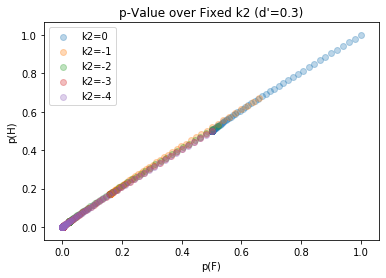

In [75]:
for i in range(len(data_pf)):
    plt.scatter(data_pf[i], data_ph[i], label=f'k2={-i}', alpha=0.3)
plt.xlabel('p(F)')
plt.ylabel('p(H)')
plt.title('p-Value over Fixed k2 (d\'=0.3)')
plt.legend()
plt.savefig('results/p_fixedk2_smalldp.png')

In [58]:
k1_range = {'k_min': 0, 'k_max': 5, 'k_num': 100}
data_zf = []
data_zh = []
for k2 in range(5):
    k_data_zf = []
    k_data_zh = []
    for k1 in np.linspace(k1_range['k_min'], k1_range['k_max'], k1_range['k_num']):
        zf,zh = diff_model.convert_k_to_z(0.3, k1, k2)
        k_data_zf.append(zf)
        k_data_zh.append(zh)
        
    data_zf.append(k_data_zf)
    data_zh.append(k_data_zh)

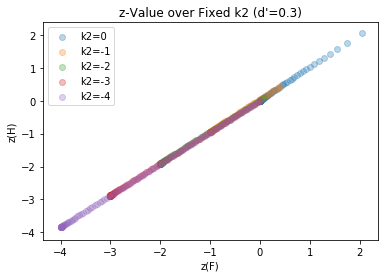

In [67]:
for i in range(len(data_zf)):
    plt.scatter(data_zf[i], data_zh[i], label=f'k2={-i}', alpha=0.3)
plt.xlabel('z(F)')
plt.ylabel('z(H)')
plt.title('z-Value over Fixed k2 (d\'=0.3)')
plt.legend()
plt.savefig('results/z_fixedk2_smalldp.png')

In [116]:
k1_range = {'k_min': 0, 'k_max': 4, 'k_num': 101}
dp_range = {'dp_min': 0, 'dp_max': 2, 'dp_num': 11}

for dp in np.linspace(dp_range['dp_min'], dp_range['dp_max'], dp_range['dp_num']):
    data_zf = []
    data_zh = []
    for k2 in range(0, 5):
        k_data_zf = []
        k_data_zh = []
        for k1 in np.linspace(k1_range['k_min'], k1_range['k_max'], k1_range['k_num']):
            zf,zh = diff_model.convert_k_to_z(dp, k1, k2)
            k_data_zf.append(zf)
            k_data_zh.append(zh)
            
        k_data_zf = [n for n in k_data_zf if abs(n) != np.inf]
        k_data_zh = [n for n in k_data_zh if abs(n) != np.inf]
        data_zf.append(k_data_zf)
        data_zh.append(k_data_zh)

    for i in range(len(data_zf)):
        model = linregress(data_zf[i], data_zh[i])
        plt.scatter(data_zf[i], data_zh[i], alpha=0.3, label=f'k2={-i}: y={round(model.intercept,3)}+{round(model.slope, 3)}x')
    plt.gcf().set_size_inches(8, 6)
    plt.xlabel('z(F)')
    plt.ylabel('z(H)')
    plt.title(f'z-Value over Fixed d\' (d\'={round(dp,2)})')
    plt.legend()
    plt.savefig(f'results/z_fixeddp{round(dp,2)}.png')
    plt.clf()

<Figure size 576x432 with 0 Axes>

In [114]:
k1_range = {'k_min': 0, 'k_max': 5, 'k_num': 100}
dp_range = {'dp_min': 0, 'dp_max': 2, 'dp_num': 11}

for dp in np.linspace(dp_range['dp_min'], dp_range['dp_max'], dp_range['dp_num']):
    data_pf = []
    data_ph = []
    for k2 in range(0, 5):
        k_data_pf = []
        k_data_ph = []
        for k1 in np.linspace(k1_range['k_min'], k1_range['k_max'], k1_range['k_num']):
            pf,ph = diff_model.convert_k_to_p(dp, k1, k2)
            k_data_pf.append(pf)
            k_data_ph.append(ph)
            
        k_data_pf = [n for n in k_data_pf if abs(n) != np.inf]
        k_data_ph = [n for n in k_data_ph if abs(n) != np.inf]
        data_pf.append(k_data_pf)
        data_ph.append(k_data_ph)

    for i in range(len(data_pf)):
        model = linregress(data_pf[i], data_ph[i])
        plt.scatter(data_pf[i], data_ph[i], alpha=0.3, label=f'k2={-i}: y={round(model.intercept,3)}+{round(model.slope, 3)}x')
    plt.gcf().set_size_inches(8, 6)
    plt.xlabel('p(F)')
    plt.ylabel('p(H)')
    plt.title(f'p-Value over Fixed d\' (d\'={round(dp,2)})')
    plt.legend()
    plt.savefig(f'results/p_fixeddp{round(dp,2)}.png')
    plt.clf()

<Figure size 576x432 with 0 Axes>